In [3]:
import os
 
# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = "malaria/cell_images"
 
# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
BASE_PATH = "malaria"
 
# derive the training, validation, and testing directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])
 
# define the amount of data that will be used training
TRAIN_SPLIT = 0.8
 
# the amount of validation data will be a percentage of the
# *training* data
VAL_SPLIT = 0.1

In [4]:
from pyimagesearch import config
from imutils import paths
import random
import shutil
import os
 
# grab the paths to all input images in the original input directory
# and shuffle them
imagePaths = list(paths.list_images(config.ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

In [5]:
# compute the training and testing split
i = int(len(imagePaths) * config.TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]
 
# we'll be using part of the training data for validation
i = int(len(trainPaths) * config.VAL_SPLIT)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]

In [6]:
datasets = [
	("training", trainPaths, config.TRAIN_PATH),
	("validation", valPaths, config.VAL_PATH),
	("testing", testPaths, config.TEST_PATH)
]

In [7]:
for (dType, imagePaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))
 
	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)
 
	# loop over the input image paths
	for inputPath in imagePaths:
		# extract the filename of the input image along with its
		# corresponding class label
		filename = inputPath.split(os.path.sep)[-1]
		label = inputPath.split(os.path.sep)[-2]
 
		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])
 
		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)
 
		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] building 'validation' split
[INFO] building 'testing' split


In [8]:
from keras.applications import VGG16

conv_base = VGG16(weights = "imagenet",
include_top = False, input_shape =(64,64,3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [9]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1 / 255.0)

In [10]:
datagen = ImageDataGenerator(rescale=1./255,
                            shear_range = 0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)
batch_size = 4


def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 2, 2, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        class_mode="binary",
        target_size=(64, 64),
        batch_size=batch_size,
        color_mode="rgb")
    
    i = 0
    for inputs_batch, labels_batch in generator:


        #print(labels_batch)
        features_batch = conv_base.predict(inputs_batch)
        #print(features_batch)
        features[i * batch_size: (i+1) * batch_size] = features_batch
        labels[i * batch_size: (i+1) * batch_size] = labels_batch
        i += 1
        #print(i)
        if ((i * batch_size % 1000) == 0 ):
            print("processed size =", i * batch_size)
        if i * batch_size >= sample_count:
            break

    return features, labels  

In [24]:
# Extract validation features
nVal = 2204
val_features, val_labels = extract_features(config.VAL_PATH, nVal)

Found 2204 images belonging to 2 classes.
processed size = 1000
processed size = 2000


In [26]:
np.save('validation_features', val_features)
np.save('validation_labels', val_labels)

In [29]:
# Extract test features
nTest = 5512
test_features, test_labels = extract_features(config.TEST_PATH, nTest)

Found 5512 images belonging to 2 classes.
processed size = 1000
processed size = 2000
processed size = 3000
processed size = 4000
processed size = 5000


In [30]:
np.save('test_features', test_features)
np.save('test_labels', test_labels)

In [21]:
# Extract train features
nTrain = 19842
train_features, train_labels = extract_features(config.TRAIN_PATH, nTrain)

Found 19842 images belonging to 2 classes.
processed size = 1000
processed size = 2000
processed size = 3000
processed size = 4000
processed size = 5000
processed size = 6000
processed size = 7000
processed size = 8000
processed size = 9000
processed size = 10000
processed size = 11000
processed size = 12000
processed size = 13000
processed size = 14000
processed size = 15000
processed size = 16000
processed size = 17000
processed size = 18000
processed size = 19000


In [22]:
np.save('train_features', train_features)
np.save('train_labels', train_labels)

# Load the features

In [11]:
train_features = np.load('train_features.npy')
test_features = np.load('test_features.npy')
validation_features = np.load('validation_features.npy')

In [12]:
train_labels = np.load('train_labels.npy')
test_labels = np.load('test_labels.npy')
validation_labels = np.load('validation_labels.npy')

In [14]:
nVal = 2204
nTrain = 19842
nTest = 5512

In [15]:
train_features = np.reshape(train_features, (nTrain, 2 * 2 * 512))
test_features = np.reshape(test_features, (nTest, 2 * 2 * 512))
validation_features = np.reshape(validation_features, (nVal, 2 * 2 * 512))

In [16]:
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
    # show which data split we are creating
    print("[INFO] building '{}' split".format(dType))
 
    # if the output base output directory does not exist, create it
    if not os.path.exists(baseOutput):
        print("[INFO] 'creating {}' directory".format(baseOutput))
        os.makedirs(baseOutput)
 
# loop over the input image paths
    for inputPath in imagePaths:
        # extract the filename of the input image along with its
        # corresponding class label
        filename = inputPath.split(os.path.sep)[-1]
        label = inputPath.split(os.path.sep)[-2]
 
        # build the path to the label directory
        labelPath = os.path.sep.join([baseOutput, label])
 
        # if the label output directory does not exist, create it
        if not os.path.exists(labelPath):
            print("[INFO] 'creating {}' directory".format(labelPath))
            os.makedirs(labelPath)
 
        # construct the path to the destination image and then copy
        # the image itself
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, p)


[INFO] building 'training' split
[INFO] building 'validation' split
[INFO] building 'testing' split


In [120]:
from keras import models
from keras import layers
from keras import optimizers
model0 = models.Sequential()
model0.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model0.add(layers.Dropout(0.5))
model0.add(layers.Dense(1, activation='sigmoid'))

model0.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model0.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=4,
                    validation_data=(validation_features, validation_labels))

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x18344db630>>
Traceback (most recent call last):
  File "/Users/anupriya/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/Users/anupriya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 140702518384672


Train on 19842 samples, validate on 2204 samples
Epoch 1/30
19842/19842 [==============================] - 26s 1ms/step - loss: 0.3701 - acc: 0.8330 - val_loss: 0.2843 - val_acc: 0.8789
Epoch 2/30
19842/19842 [==============================] - 21s 1ms/step - loss: 0.2637 - acc: 0.8922 - val_loss: 0.2582 - val_acc: 0.8902
Epoch 3/30
19842/19842 [==============================] - 22s 1ms/step - loss: 0.2394 - acc: 0.9037 - val_loss: 0.2455 - val_acc: 0.8970
Epoch 4/30
19842/19842 [==============================] - 21s 1ms/step - loss: 0.2281 - acc: 0.9098 - val_loss: 0.2376 - val_acc: 0.9015
Epoch 5/30
19842/19842 [==============================] - 21s 1ms/step - loss: 0.2192 - acc: 0.9164 - val_loss: 0.2347 - val_acc: 0.9056
Epoch 6/30
19842/19842 [==============================] - 22s 1ms/step - loss: 0.2156 - acc: 0.9196 - val_loss: 0.2290 - val_acc: 0.9106
Epoch 7/30
19842/19842 [==============================] - 22s 1ms/step - loss: 0.2116 - acc: 0.9223 - val_loss: 0.2366 - val_acc:

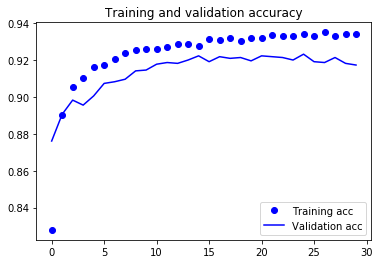

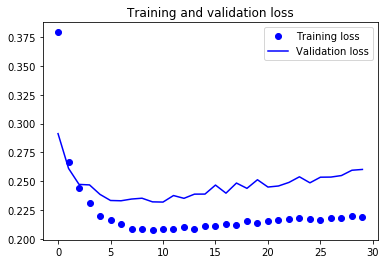

In [37]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [122]:
model0.evaluate(test_features,test_labels)

5512/5512 [==============================] - 1s 104us/step


[0.23705693252157578, 0.931966618287373]

In [38]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))

model.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
#model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=4,
                    validation_data=(validation_features, validation_labels))

Train on 19842 samples, validate on 2204 samples
Epoch 1/30
19842/19842 [==============================] - 28s 1ms/step - loss: 0.5031 - acc: 0.7482 - val_loss: 0.3197 - val_acc: 0.8607
Epoch 2/30
19842/19842 [==============================] - 27s 1ms/step - loss: 0.3113 - acc: 0.8709 - val_loss: 0.2824 - val_acc: 0.8834
Epoch 3/30
19842/19842 [==============================] - 26s 1ms/step - loss: 0.2736 - acc: 0.8937 - val_loss: 0.2697 - val_acc: 0.8934
Epoch 4/30
19842/19842 [==============================] - 24s 1ms/step - loss: 0.2571 - acc: 0.9070 - val_loss: 0.2645 - val_acc: 0.8979
Epoch 5/30
19842/19842 [==============================] - 24s 1ms/step - loss: 0.2490 - acc: 0.9140 - val_loss: 0.2622 - val_acc: 0.9083
Epoch 6/30
19842/19842 [==============================] - 24s 1ms/step - loss: 0.2465 - acc: 0.9181 - val_loss: 0.2668 - val_acc: 0.9093
Epoch 7/30
19842/19842 [==============================] - 24s 1ms/step - loss: 0.2484 - acc: 0.9219 - val_loss: 0.2810 - val_acc:

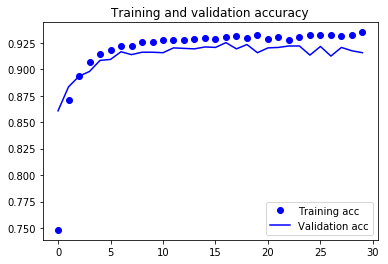

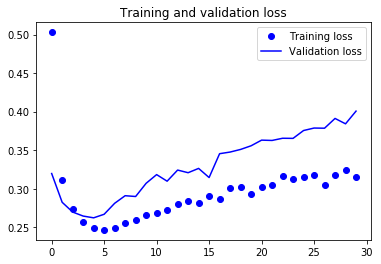

In [39]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [94]:
model.evaluate(test_features,test_labels)

5512/5512 [==============================] - 0s 60us/step


[0.36444450198998474, 0.9299709724238027]

In [93]:
predict_features = model.predict(test_features)

In [101]:
#model.evaluate(test_features,predict_features)

5512/5512 [==============================] - 0s 61us/step


[0.08074419366950047, 0.09687953555878084]

In [60]:
from keras import models
from keras import layers
from keras import optimizers
model2 = models.Sequential()
model2.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history2 = model2.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=4,
                    validation_data=(validation_features, validation_labels))

Train on 19842 samples, validate on 2204 samples
Epoch 1/30
19842/19842 [==============================] - 24s 1ms/step - loss: 0.3649 - acc: 0.8397 - val_loss: 0.2616 - val_acc: 0.8897
Epoch 2/30
19842/19842 [==============================] - 24s 1ms/step - loss: 0.2449 - acc: 0.9015 - val_loss: 0.2298 - val_acc: 0.9056
Epoch 3/30
19842/19842 [==============================] - 24s 1ms/step - loss: 0.2164 - acc: 0.9150 - val_loss: 0.2166 - val_acc: 0.9106
Epoch 4/30
19842/19842 [==============================] - 23s 1ms/step - loss: 0.1972 - acc: 0.9227 - val_loss: 0.2127 - val_acc: 0.9156
Epoch 5/30
19842/19842 [==============================] - 24s 1ms/step - loss: 0.1902 - acc: 0.9270 - val_loss: 0.2148 - val_acc: 0.9129
Epoch 6/30
19842/19842 [==============================] - 23s 1ms/step - loss: 0.1811 - acc: 0.9307 - val_loss: 0.1947 - val_acc: 0.9274
Epoch 7/30
19842/19842 [==============================] - 24s 1ms/step - loss: 0.1740 - acc: 0.9336 - val_loss: 0.1951 - val_acc:

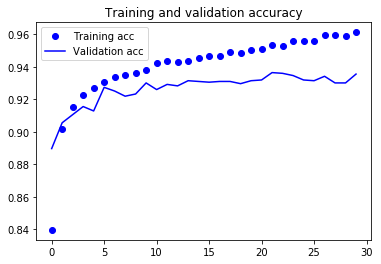

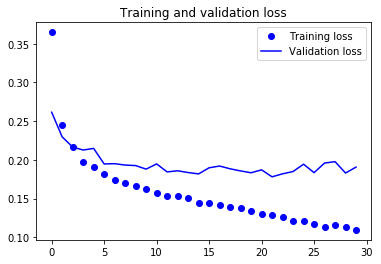

In [61]:
import matplotlib.pyplot as plt

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [62]:
model2.evaluate(test_features,test_labels)

5512/5512 [==============================] - 0s 62us/step


[0.17178268368924995, 0.9368650217706821]

In [52]:
validation_features.shape

(2204, 2048)

In [53]:
train_features.shape

(19842, 2048)

In [84]:
from keras import models
from keras import layers
from keras import optimizers
model1 = models.Sequential()
model1.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model1.add(layers.Dropout(0.7))
model1.add(layers.Dense(256, activation = "relu", input_dim = 2 * 2 * 512))
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model1.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=4,
                    validation_data=(validation_features, validation_labels))

Train on 19842 samples, validate on 2204 samples
Epoch 1/30
19842/19842 [==============================] - 27s 1ms/step - loss: 0.3586 - acc: 0.8505 - val_loss: 0.2679 - val_acc: 0.8970
Epoch 2/30
19842/19842 [==============================] - 27s 1ms/step - loss: 0.2945 - acc: 0.8907 - val_loss: 0.2938 - val_acc: 0.8684
Epoch 3/30
19842/19842 [==============================] - 25s 1ms/step - loss: 0.2731 - acc: 0.8993 - val_loss: 0.2257 - val_acc: 0.9138
Epoch 4/30
19842/19842 [==============================] - 26s 1ms/step - loss: 0.2639 - acc: 0.9054 - val_loss: 0.2306 - val_acc: 0.9156
Epoch 5/30
19842/19842 [==============================] - 29s 1ms/step - loss: 0.2596 - acc: 0.9071 - val_loss: 0.2328 - val_acc: 0.9142
Epoch 6/30
19842/19842 [==============================] - 29s 1ms/step - loss: 0.2547 - acc: 0.9097 - val_loss: 0.2431 - val_acc: 0.9020
Epoch 7/30
19842/19842 [==============================] - 26s 1ms/step - loss: 0.2525 - acc: 0.9117 - val_loss: 0.2404 - val_acc:

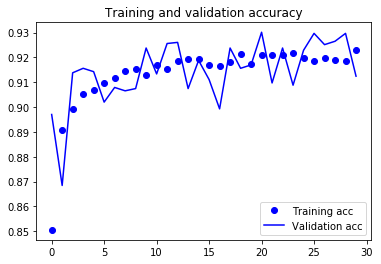

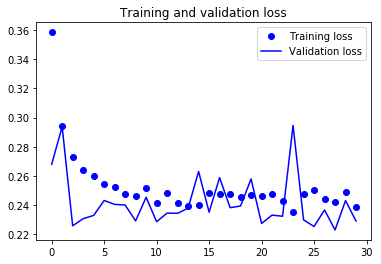

In [85]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [97]:
model1.evaluate(test_features,test_labels)

5512/5512 [==============================] - 0s 60us/step


[0.21977549151170064, 0.9123730043541364]

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from keras.layers.convolutional import Conv2D
from keras.layers import Activation, Dense, MaxPooling2D,Flatten


from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))  #Dropout for regularization
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes



model3.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model3.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=4,
                    validation_data=(validation_features, validation_labels))

In [ ]:
#input_shape=(2,2,512)
model3 = models.Sequential()
#model3.add(Conv2D(32,(4,4), input_shape= input_shape))
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=2))

model3.add(Flatten())
model3.add(layers.Dense(64, activation = "relu", input_dim = 2 * 2 * 512))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from keras.layers.convolutional import Conv2D
from keras.layers import Activation, Dense, MaxPooling2D,Flatten
input_shape=(2,2,512)
model3 = models.Sequential()
model3.add(layers.GlobalAveragePooling2D(input_shape=(2,2,512)))
model3.add(layers.Dense(1, activation='sigmoid'))


model3.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model3.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=4,
                    validation_data=(validation_features, validation_labels))

In [ ]:
testPaths[100:120]

In [49]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = testPaths
        #print(path)
        # Get picture
        random_img = random.choice(testPaths)
        #print(random_img)
        for img_p in testPaths[77:81]:
            img_path = img_p
            #print(img_path)
            img = image.load_img(img_path, target_size=(64, 64))
            img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
            img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

            # Extract features
            features = conv_base.predict(img_tensor.reshape(1,64, 64, 3))

            # Make prediction
            try:
                prediction = classifier.predict(features)
            except:
                prediction = classifier.predict(features.reshape(1, 2*2*512))

            # Show picture
            plt.imshow(img_tensor)
            plt.show()

            # Write prediction
            if prediction < 0.5:
                print('This is Parasitized')
            else:
                print('This is Uninfected')

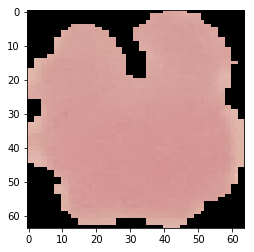

This is Uninfected


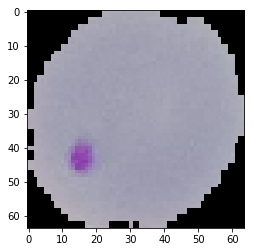

This is Parasitized


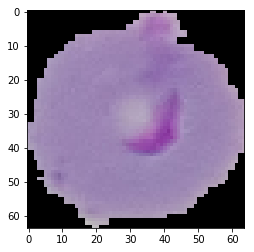

This is Parasitized


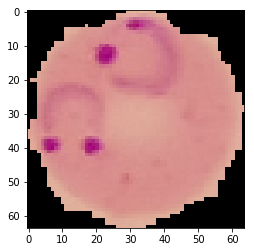

This is Parasitized


In [50]:
from keras.preprocessing import image
# Visualize predictions
visualize_predictions(model2, 1)